In [12]:
!pip install music21 tensorflow[and-cuda] numpy matplotlib pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 25.3 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [14]:
# Cell 1: Import necessary libraries
import glob
import music21
import numpy as np
import pydot
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical, plot_model

In [15]:
# Cell 2: Helper functions for MIDI processing
def parse_midi_file(file_path):
    """Extract notes and chords from a MIDI file."""
    try:
        midi_stream = music21.converter.parse(file_path)
        notes = []
        for element in midi_stream.flat.notes:
            if isinstance(element, music21.note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, music21.chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
        return notes
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def prepare_sequences(notes, sequence_length):
    """Prepare input and output sequences for training."""
    pitch_names = sorted(set(notes))
    note_to_int = {note: num for num, note in enumerate(pitch_names)}
    network_input = []
    network_output = []

    for i in range(0, len(notes) - sequence_length):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[note] for note in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(len(pitch_names))
    network_output = to_categorical(network_output)

    return network_input, network_output, note_to_int, pitch_names

In [16]:
# Cell 3: Load and process MIDI files
data_folder = './midi_songs/*.mid'  # Replace with the root folder containing MIDI files
midi_files = glob.glob(data_folder, recursive=True)

if not midi_files:
    raise ValueError("No MIDI files found. Please check the folder path.")

print(f"Found {len(midi_files)} MIDI files for processing.")

all_notes = []
file_stats = []

for file_path in midi_files:
    notes = parse_midi_file(file_path)
    all_notes.extend(notes)
    file_stats.append((file_path, len(notes)))

if not all_notes:
    raise ValueError("No notes extracted from the MIDI files. Ensure files contain valid musical data.")

print(f"Extracted {len(all_notes)} total notes from the dataset.")

# Overview of MIDI files processed
file_stats.sort(key=lambda x: x[1], reverse=True)  # Sort by number of notes
print("\nOverview of MIDI files:")
for i, (file_path, note_count) in enumerate(file_stats[:10]):
    print(f"{i+1}. {file_path} - {note_count} notes")

Found 29 MIDI files for processing.
Extracted 80709 total notes from the dataset.

Overview of MIDI files:
1. ./midi_songs/I'll Be Waiting.mid - 5101 notes
2. ./midi_songs/Hometown Glory.mid - 4734 notes
3. ./midi_songs/He Won't Go.mid - 4251 notes
4. ./midi_songs/First Love.mid - 4208 notes
5. ./midi_songs/Rumour Has It.mid - 4188 notes
6. ./midi_songs/Right As Rain.mid - 4108 notes
7. ./midi_songs/Lovesong.mid - 4058 notes
8. ./midi_songs/One And Only.mid - 4002 notes
9. ./midi_songs/Best For Last.mid - 3989 notes
10. ./midi_songs/My Same.mid - 3918 notes


In [23]:
# Cell 4: Prepare sequences
sequence_length = 50  # Define sequence length for LSTM training
network_input, network_output, note_to_int, pitch_names = prepare_sequences(all_notes, sequence_length)

if network_input.shape[0] == 0:
    raise ValueError("Not enough data to create sequences. Ensure MIDI files contain sufficient notes.")

print(f"Input shape: {network_input.shape}, Output shape: {network_output.shape}")

Input shape: (80659, 50, 1), Output shape: (80659, 355)


In [27]:
# Cell 5: Build LSTM model
def build_lstm_model(input_shape, output_units):
    """Build a robust LSTM model."""
    model = Sequential([
        LSTM(512, input_shape=input_shape, return_sequences=True),
        Dropout(0.3),
        LSTM(512, return_sequences=True),
        Dropout(0.3),
        LSTM(512),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(output_units, activation='softmax')
    ])
   # Compile the model with both loss and accuracy metrics
    model.compile(
        optimizer='adam', 
        loss='categorical_crossentropy',  # Use appropriate loss based on your output
        metrics=['accuracy']             # Include accuracy as a metric
    )
    return model

model = build_lstm_model((network_input.shape[1], network_input.shape[2]), len(pitch_names))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 50, 512)        │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 50, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50, 512)        │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 355)            │        91,235 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,473,635 (20.88 MB)

 Trainable params: 5,473,635 (20.88 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Cell 6: Save model architecture as a graph
plot_path = 'lstm_music_model_architecture.png'
plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)
print(f"Model architecture graph saved as {plot_path}.")

You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture graph saved as lstm_music_model_architecture.png.


In [29]:
"""
Train the neural network for generating music sequences.

This training setup adjusts model weights using robust callbacks to monitor 
both loss and accuracy, dynamically adjust the learning rate, and save the best 
model. The focus is on minimizing loss and maximizing accuracy.
"""

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define callbacks for efficient and robust training
callbacks = [
    # Save the best model based on the lowest loss
    ModelCheckpoint(
        filepath='best_lstm_music_model.keras',  # Save path for the best model
        monitor='loss',                          # Monitor training loss
        save_best_only=True,                     # Save only when loss improves
        mode='min',                              # Minimize the loss
        verbose=1                                # Show checkpointing details
    ),
    # Dynamically reduce learning rate when training stagnates
    ReduceLROnPlateau(
        monitor='loss', 
        factor=0.5,                              # Halve the learning rate
        patience=5,                              # Wait for 5 epochs with no improvement
        min_lr=1e-6,                             # Set a floor for the learning rate
        verbose=1                                # Log learning rate adjustments
    ),
    # Stop training early if no improvement is observed
    EarlyStopping(
        monitor='loss', 
        patience=10,                             # Wait for 10 epochs of no improvement
        restore_best_weights=True,              # Load the best weights on stop
        verbose=1                                # Show early stopping details
    )
]

# Train the model
history = model.fit(
    network_input,    # Input data (normalized sequences)
    network_output,   # Output data (target sequences)
    epochs=100,       # Number of epochs to train
    batch_size=128,   # Size of each training batch
    callbacks=callbacks,  # Attach the robust callbacks
    verbose=1,        # Show detailed training progress
    validation_split=0.2  # Split 20% of data for validation
)

# Print training results
print("Training complete! The best model has been saved as 'best_lstm_music_model.keras'.")


Epoch 1/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0371 - loss: 4.6696
Epoch 1: loss improved from inf to 4.56181, saving model to best_lstm_music_model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.0371 - loss: 4.6694 - val_accuracy: 0.0430 - val_loss: 4.8577 - learning_rate: 0.0010
Epoch 2/100
502/505 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0414 - loss: 4.5032
Epoch 2: loss improved from 4.56181 to 4.50465, saving model to best_lstm_music_model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.0414 - loss: 4.5032 - val_accuracy: 0.0307 - val_loss: 4.8812 - learning_rate: 0.0010
Epoch 3/100
505/505 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0411 - loss: 4.4862
Epoch 3: loss improved from 4.50465 to 4.49660, saving model to best_lstm_music_model.keras
505/505 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.0411 - loss: 4.4862 - val_accuracy: 0.0430 - val_loss: 4.8227 - learning_rate: 0.0010
Epoch 4/100
505/505 ━━━━━━━━━━━━━━━

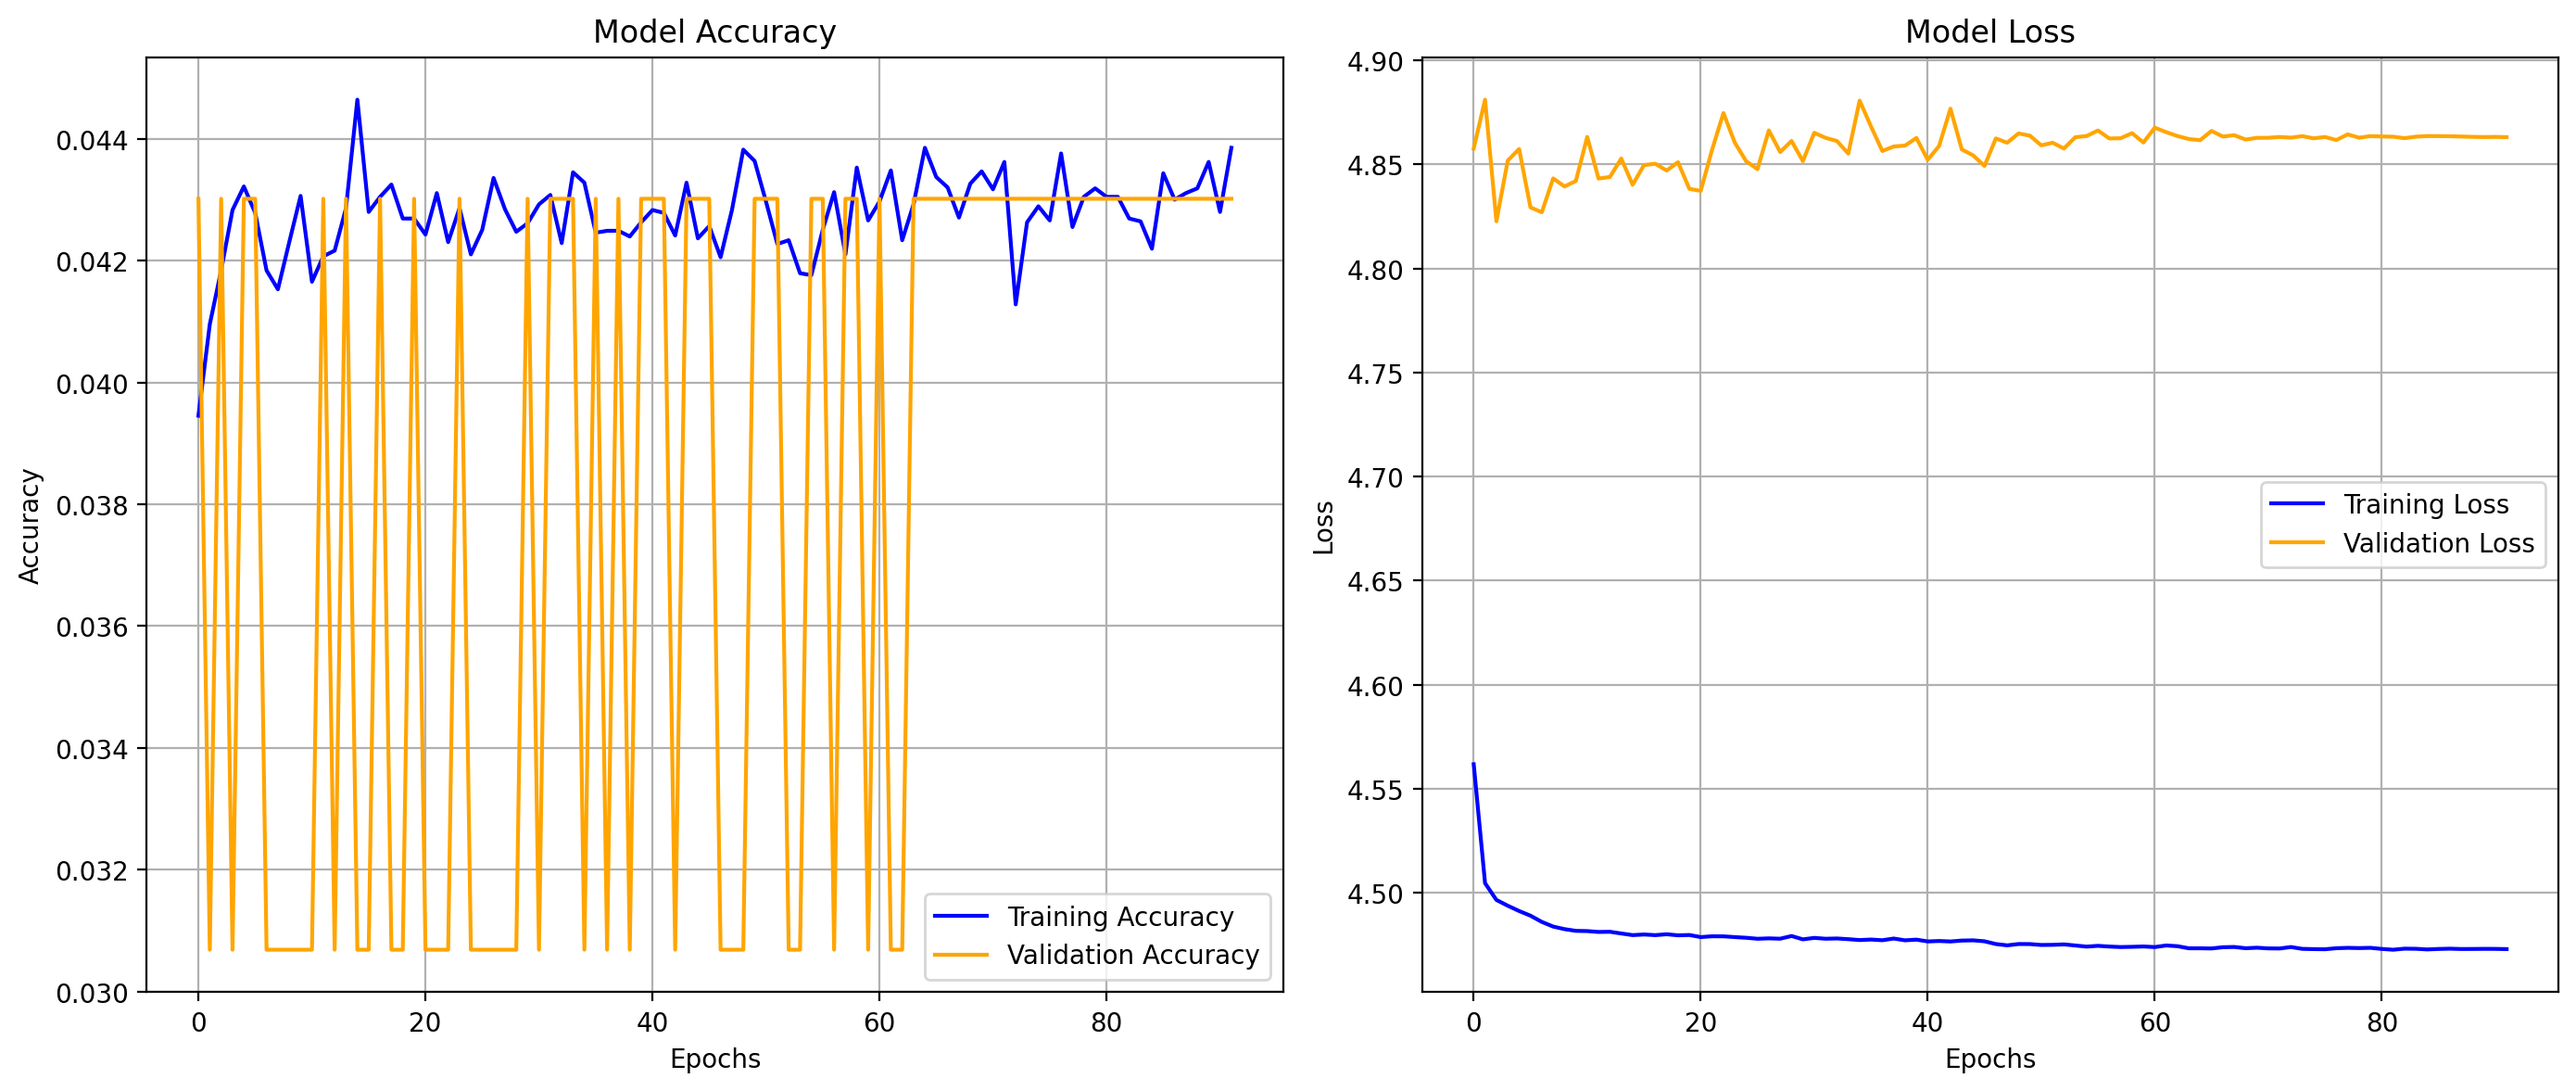

In [30]:
# Cell 8: Plot training accuracy and loss
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot training and validation accuracy and loss."""
    plt.figure(figsize=(14, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300)
    plt.show()

# Call the function to visualize the training history
plot_training_history(history)